In [1]:
import os
os.chdir('C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\pyimagesearch')
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import pydot
import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Dense, Lambda, RepeatVector
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate
from tensorflow.keras.regularizers import l2
import glob

In [2]:
class PC:
    @staticmethod
    def conv_module(x, num_filter, kr, stride ,padding="same", reg=0.0005, name=None):
        # initialize the CONV, BN, and RELU layer names
        (convName, bnName, actName) = (None, None, None)
        
        # if a layer name was supplied, prepend it
        if name is not None:
            convName = name + "_conv"
            bnName = name + "_bn"
            actName = name + "_act"
        # define a CONV => BN => RELU pattern
        x = Conv1D(num_filter, kr, strides=stride, padding=padding, kernel_regularizer=l2(reg),name=convName)(x)
        x = BatchNormalization(axis=-1, name=bnName)(x)
        x = Activation("selu", name=actName)(x)
        
        # return the block
        return x
    
    @staticmethod
    def inception_module(x, num1x1, num3x3Reduce, num3x3,num5x5Reduce, num5x5, stage, reg=0.0005):
        # define the first branch of the Inception module which
        # consists of 1x1 convolutions
        first = PC.conv_module(x, num1x1, 1, 1, reg=reg, name=stage + "_first")
        
        # define the second branch of the Inception module which
        # consists of 1x1 and 3x3 convolutions
        second = PC.conv_module(x, num3x3Reduce, 1, 1,  reg=reg, name=stage + "_second1")
        second = PC.conv_module(second, num3x3, 3, 1, reg=reg, name=stage + "_second2")
        
        # define the third branch of the Inception module which
        # are our 1x1 and 5x5 convolutions
        third = PC.conv_module(x, num5x5Reduce, 1, 1,  reg=reg, name=stage + "_third1")
        third = PC.conv_module(third, num5x5, 5, 1,  reg=reg, name=stage + "_third2")
        
        # concatenate across the channel dimension
        x = concatenate([first, second, third], axis=-1 ,name=stage + "_mixed")
        
        # return the block
        return x

In [3]:
#3.72
time_steps=24
num_features=22
def hybrid():
    inputs = Input(shape=(time_steps, num_features))
    lstm1, h, c = LSTM(48, return_sequences=True, return_state=True)(inputs)
    
    lstm2, h, c = LSTM(48, return_sequences=True, return_state=True)(lstm1)
    
    incp1 = PC.inception_module(lstm2, 32, 32, 64, 8, 32, "2a")    

    incp2 = PC.inception_module(incp1, 64, 64, 128, 16, 64, "3a")
    
    #.......................................................................

    flat = Flatten()(incp2)
    
    x = Activation('tanh')(flat)
    x=Dropout(0.2)(x)
    x = Dense(24, activation="sigmoid")(x)
    #.......................................................................
    model = Model(inputs, x)
    return model

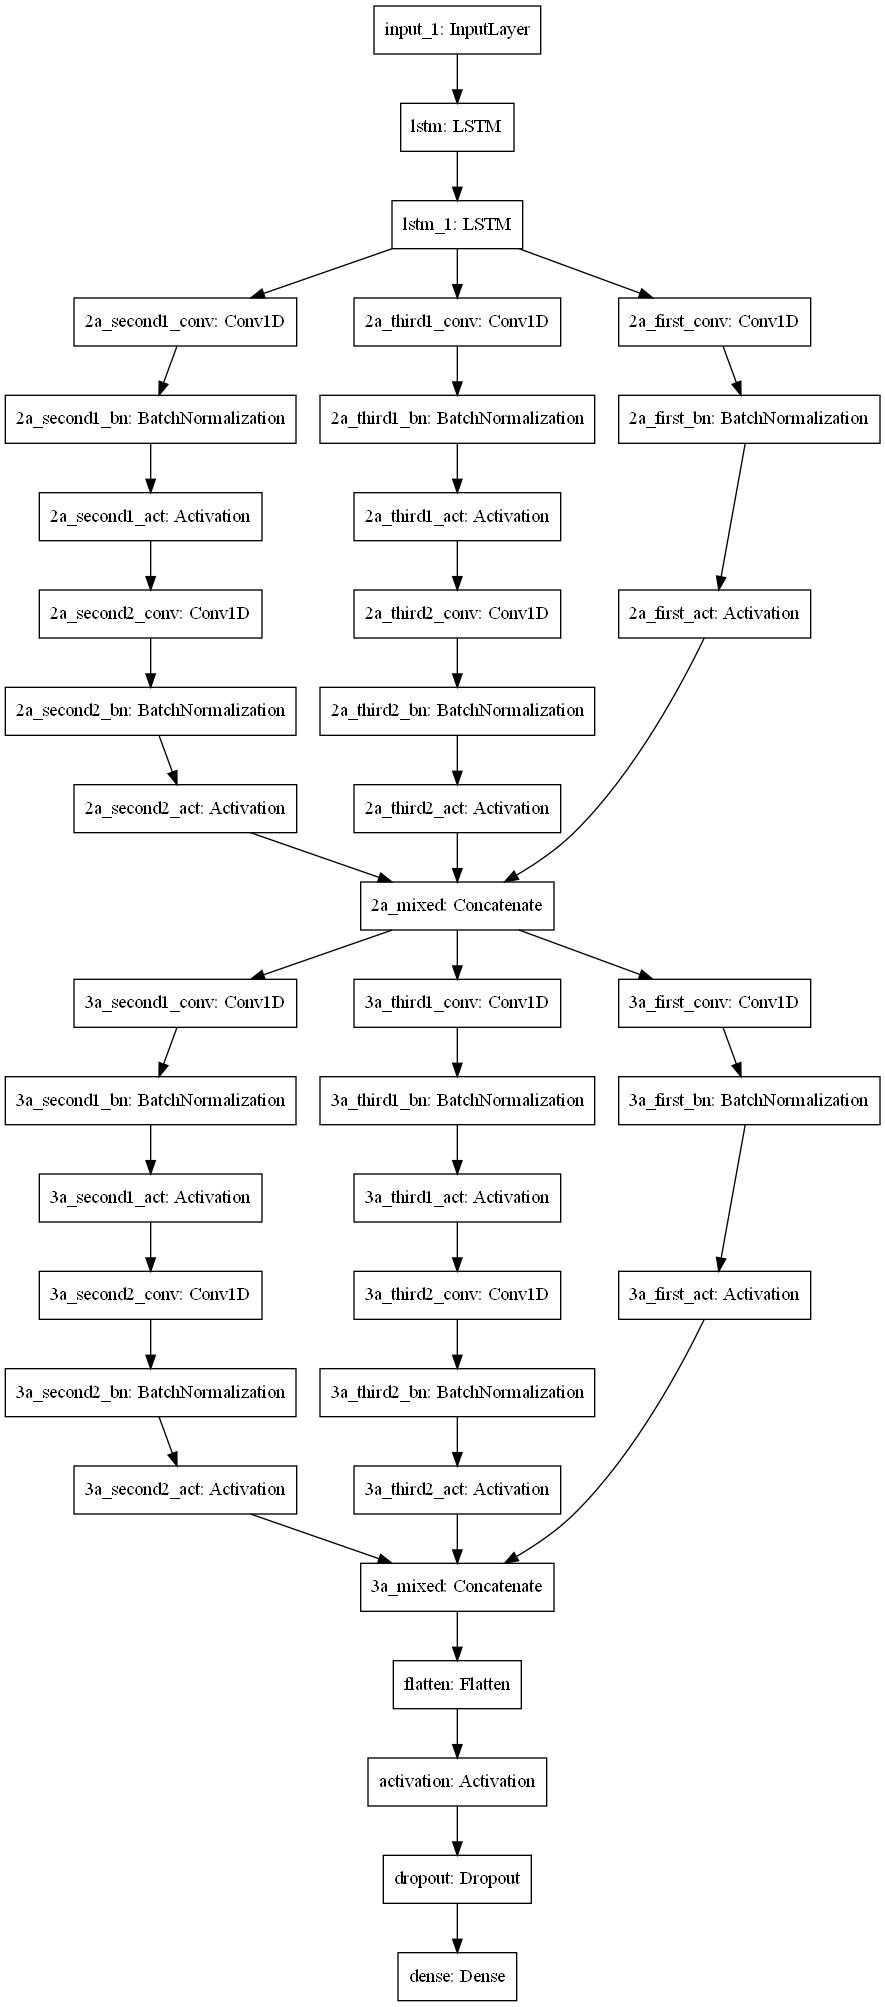

In [4]:
model = hybrid()
tensorflow.keras.utils.plot_model(model)

In [5]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 22)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 24, 48), (No 13632       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 24, 48), (No 18624       lstm[0][0]                       
__________________________________________________________________________________________________
2a_second1_conv (Conv1D)        (None, 24, 32)       1568        lstm_1[0][0]                     
_______________________________________________________________________________________

In [21]:
checkpoints = 'D:\\Checkpoints\\6_MDPI\\Multistep\\20_ISONE_WithOutTemprature\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = 'D:\\Checkpoints\\6_MDPI\\Multistep\\20_ISONE_WithOutTemprature'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"history.json"])

In [22]:
model = None
start_epoch = 0
time_steps=24
num_features=21

In [23]:
import os
path_dataset = 'C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\ISONE\\'
path_tr = os.path.join(path_dataset, 'ISONE_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:,[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]].values #dataset=np.array(df) dwara use koli sho
#train_set = df_tr.iloc[:].values #dataset=np.array(df) dwara use koli sho
path_v = os.path.join(path_dataset, 'ISONE_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:,[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]].values #dataset=np.array(df) dwara use koli sho
#validation_set = df_v.iloc[:].values #dataset=np.array(df) dwara use koli sho
path_te = os.path.join(path_dataset, 'ISONE_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:,[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]].values #dataset=np.array(df) dwara use koli sho
#test_set = df_te.iloc[:].values #dataset=np.array(df) dwara use koli sho

In [24]:
start = time.time()
train_X, train_y = multivariate_multi_step(train_set, time_steps = time_steps, target_col = 0,target_len=24,ahead=0)
validation_X, validation_y = multivariate_multi_step(validation_set, time_steps =time_steps ,target_col=0,target_len=24,ahead=0)
test_X, test_y = multivariate_multi_step(test_set, time_steps = time_steps, target_col= 0,target_len=24,ahead=0)
print('Time Consumed',time.time()-start,"sec")

Time Consumed 0.3227195739746094 sec


In [25]:
train_X.shape

(67454, 24, 21)

In [26]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = hybrid()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [27]:
epochs = 30
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   #pa batch 16 mape 7.72%
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)


Epoch 1/30
2105/2108 [============================>.] - ETA: 0s - loss: 0.1032 - mae: 0.0626 - mape: 2144.1436
Epoch 00001: val_loss improved from inf to 0.05822, saving model to D:\Checkpoints\6_MDPI\Multistep\20_ISONE_WithOutTemprature\E1-cp-0001-loss0.06.h5
2108/2108 [==============================] - 37s 18ms/step - loss: 0.1031 - mae: 0.0626 - mape: 2141.1741 - val_loss: 0.0582 - val_mae: 0.0529 - val_mape: 22.8899
Epoch 2/30
2106/2108 [============================>.] - ETA: 0s - loss: 0.0396 - mae: 0.0361 - mape: 1870.9794
Epoch 00002: val_loss improved from 0.05822 to 0.03482, saving model to D:\Checkpoints\6_MDPI\Multistep\20_ISONE_WithOutTemprature\E1-cp-0002-loss0.03.h5
2108/2108 [==============================] - 36s 17ms/step - loss: 0.0396 - mae: 0.0361 - mape: 1869.2698 - val_loss: 0.0348 - val_mae: 0.0323 - val_mape: 13.3563
Epoch 3/30
2107/2108 [============================>.] - ETA: 0s - loss: 0.0322 - mae: 0.0301 - mape: 1858.5282
Epoch 00003: val_loss improved from 0

Epoch 24/30
2105/2108 [============================>.] - ETA: 0s - loss: 0.0215 - mae: 0.0209 - mape: 1769.4485
Epoch 00024: val_loss did not improve from 0.02320
2108/2108 [==============================] - 36s 17ms/step - loss: 0.0215 - mae: 0.0209 - mape: 1766.9921 - val_loss: 0.0246 - val_mae: 0.0240 - val_mape: 8.9274
Epoch 25/30
2107/2108 [============================>.] - ETA: 0s - loss: 0.0213 - mae: 0.0207 - mape: 1748.4650- ETA: 2s - loss:
Epoch 00025: val_loss did not improve from 0.02320
2108/2108 [==============================] - 35s 17ms/step - loss: 0.0213 - mae: 0.0207 - mape: 1747.6907 - val_loss: 0.0238 - val_mae: 0.0232 - val_mape: 8.9603
Epoch 26/30
2107/2108 [============================>.] - ETA: 0s - loss: 0.0212 - mae: 0.0207 - mape: 1760.4515
Epoch 00026: val_loss did not improve from 0.02320
2108/2108 [==============================] - 35s 17ms/step - loss: 0.0212 - mae: 0.0207 - mape: 1759.6716 - val_loss: 0.0236 - val_mae: 0.0231 - val_mape: 9.1216
Epoch 27

In [28]:
model = load_model('D:\\Checkpoints\\6_MDPI\\Multistep\\20_ISONE_WithOutTemprature\\E1-cp-0023-loss0.02.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\ISONE\\ISONE_scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 446.54
Median Absolute Error (MedAE): 315.67
Mean Squared Error (MSE): 434231.94
Root Mean Squared Error (RMSE): 658.96
Mean Absolute Percentage Error (MAPE): 3.04 %
Median Absolute Percentage Error (MDAPE): 2.27 %


y_test_unscaled.shape=  (9596, 24)
y_pred.shape=  (9596, 24)


# Tunining

In [29]:
checkpoints = 'D:\\Checkpoints\\6_MDPI\\Multistep\\20_ISONE_WithOutTemprature\\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model='D:\\Checkpoints\\6_MDPI\\Multistep\\20_ISONE_WithOutTemprature\\E1-cp-0023-loss0.02.h5'
start_epoch= 24

In [30]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=17, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading D:\Checkpoints\6_MDPI\Multistep\20_ISONE_WithOutTemprature\E1-cp-0023-loss0.02.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [31]:
epochs = 30
verbose = 1 #0
batch_size = 256
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/30
264/264 [==============================] - ETA: 0s - loss: 0.0194 - mean_absolute_error: 0.0189 - mean_absolute_percentage_error: 1690.1978
Epoch 00001: val_loss improved from inf to 0.02226, saving model to D:\Checkpoints\6_MDPI\Multistep\20_ISONE_WithOutTemprature\E2-cp-0001-loss0.02.h5
264/264 [==============================] - 30s 112ms/step - loss: 0.0194 - mean_absolute_error: 0.0189 - mean_absolute_percentage_error: 1690.1978 - val_loss: 0.0223 - val_mean_absolute_error: 0.0217 - val_mean_absolute_percentage_error: 8.4503
Epoch 2/30
264/264 [==============================] - ETA: 0s - loss: 0.0190 - mean_absolute_error: 0.0185 - mean_absolute_percentage_error: 1668.5424
Epoch 00002: val_loss improved from 0.02226 to 0.02213, saving model to D:\Checkpoints\6_MDPI\Multistep\20_ISONE_WithOutTemprature\E2-cp-0002-loss0.02.h5
264/264 [==============================] - 28s 108ms/step - loss: 0.0190 - mean_absolute_error: 0.0185 - mean_absolute_percentage_error: 1668.5424 - 

Epoch 18/30
263/264 [============================>.] - ETA: 0s - loss: 0.0183 - mean_absolute_error: 0.0180 - mean_absolute_percentage_error: 1663.6864
Epoch 00018: val_loss did not improve from 0.02193
264/264 [==============================] - 28s 107ms/step - loss: 0.0183 - mean_absolute_error: 0.0180 - mean_absolute_percentage_error: 1660.5901 - val_loss: 0.0221 - val_mean_absolute_error: 0.0217 - val_mean_absolute_percentage_error: 8.3502
Epoch 19/30
263/264 [============================>.] - ETA: 0s - loss: 0.0182 - mean_absolute_error: 0.0179 - mean_absolute_percentage_error: 1643.2958
Epoch 00019: val_loss did not improve from 0.02193
264/264 [==============================] - 28s 107ms/step - loss: 0.0182 - mean_absolute_error: 0.0179 - mean_absolute_percentage_error: 1640.2368 - val_loss: 0.0222 - val_mean_absolute_error: 0.0219 - val_mean_absolute_percentage_error: 8.4320
Epoch 20/30
264/264 [==============================] - ETA: 0s - loss: 0.0182 - mean_absolute_error: 0.0

In [33]:
model = load_model('D:\\Checkpoints\\6_MDPI\\Multistep\\20_ISONE_WithOutTemprature\\E2-cp-0022-loss0.02.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\ISONE\\ISONE_scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 425.26
Median Absolute Error (MedAE): 282.09
Mean Squared Error (MSE): 437578.99
Root Mean Squared Error (RMSE): 661.5
Mean Absolute Percentage Error (MAPE): 2.89 %
Median Absolute Percentage Error (MDAPE): 2.01 %


y_test_unscaled.shape=  (9596, 24)
y_pred.shape=  (9596, 24)


# Tune 2

In [33]:
checkpoints = 'D:\\Checkpoints\\6_MDPI\\Multistep\\13\\E3-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model='D:\\Checkpoints\\6_MDPI\\Multistep\\13\\E2-cp-0024-loss0.03.h5'
start_epoch= 15+24

In [34]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=17, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-5)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading D:\Checkpoints\6_MDPI\Multistep\13\E2-cp-0024-loss0.03.h5...
[INFO] old learning rate: 9.999999747378752e-05
[INFO] new learning rate: 9.999999747378752e-06


In [35]:
epochs = 20
verbose = 1 #0
batch_size = 1024
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.0229 - mean_absolute_percentage_error: 9068.5088
Epoch 00001: val_loss improved from inf to 0.02759, saving model to D:\Checkpoints\6_MDPI\Multistep\13\E3-cp-0001-loss0.03.h5
32/32 [==============================] - 17s 534ms/step - loss: 0.0231 - mean_absolute_error: 0.0229 - mean_absolute_percentage_error: 9068.5088 - val_loss: 0.0276 - val_mean_absolute_error: 0.0274 - val_mean_absolute_percentage_error: 4.7865
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.0229 - mean_absolute_percentage_error: 9177.2305
Epoch 00002: val_loss did not improve from 0.02759
32/32 [==============================] - 16s 492ms/step - loss: 0.0231 - mean_absolute_error: 0.0229 - mean_absolute_percentage_error: 9177.2305 - val_loss: 0.0276 - val_mean_absolute_error: 0.0274 - val_mean_absolute_percentage_error: 4.7897
Epoch 3/20
32/32 [=====================

In [36]:
model = load_model('D:\\Checkpoints\\6_MDPI\\Multistep\\14\\E1-cp-0019-loss0.03.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\AEP\\AEP_scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 370.91
Median Absolute Error (MedAE): 288.05
Mean Squared Error (MSE): 250523.34
Root Mean Squared Error (RMSE): 500.52
Mean Absolute Percentage Error (MAPE): 3.72 %
Median Absolute Percentage Error (MDAPE): 2.8 %


y_test_unscaled.shape=  (4624, 24)
y_pred.shape=  (4624, 24)
